# <font size="5"><div style="text-align: center"> BCG Machine Learning Project </div></font>


## Giacomo Mutti 
## Student ID: 10529894 

## **Table of contents**

1. [**Introduction**](#section_1)
2. [**Exploratory Data Analysis**](#section_2)
3. [**Clustering**](#section_3)
4. [**Classification**](#section_4)
5. [**Regression**](#section_5)
6. [**Classification with SOD1**](#section_6)
7. [**Discussion**](#section_7)


<a id='section_1'></a>
## 1. Introduction

This dataset comes from the Higuera et al. 2015 paper ['Self-Organizing Feature Maps Identify Proteins Critical to Learning in a Mouse Model of Down Syndrome'](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0129126). In this study 77 protein expression levels were measured in 8 different classes of mice to assess the effect of such proteins in the learning process especially in Down Syndrome (DS). The expression levels were measured through reverse phase protein arrays (RPPA), this technique allows for high-throughput and very sensitive protein expression levels detection. So we can reasonably assume that these data are reliable and that the quantities properly reflect the actual values. The assay was performed on the nuclear fraction of the cortex of 72 mice (this dataset consists of 367 train observation and 245 test observations though).

Mice were divided in 8 class based on 3 dichotomous criteria [(vd Fig 1.1)](#fig1.1):
 1. *Down syndrome (t) or control (c)*
 2. *Context shock (CS) or shock context (SC)*
 3. *memantine drug (m) or saline injection (s)*
 
The data were collected on brain lysates of 3 months old Ts65Dn Down model mice (t) and their littermate wild type (c) to control for the effect of the trisomy.
Some of these mice were injected with memantine (m). This drug is currently in use to cure Alzheimer's disease and it seems like a suggesting molecule to solve some learning deficit also in DS. The rest of the mice were injected with a saline solution to control for the effect of the drug. Finally mice were also divided by which learning context they were exposed to. CS if the shock is given after the mice explores the cage (in this case wild type mice learn to associate the context with the shock). SC if the shock is immediately given before the mouse is allowed to explore the cage (in these cases the context should not be associated to the punishment).

Theoretically the mice that will learn will be C-cs, in t-CS-m the learning will be rescued thanks to the drug and t-cs-s would fail to learn. All the SC mice should not learn.

It is important to note that there are no missing values however the test data completely miss the measurement of the protein SOD1 because of a malfunctioning in the analysis.
<a id='fig1.1'></a>
#### Fig.1.1

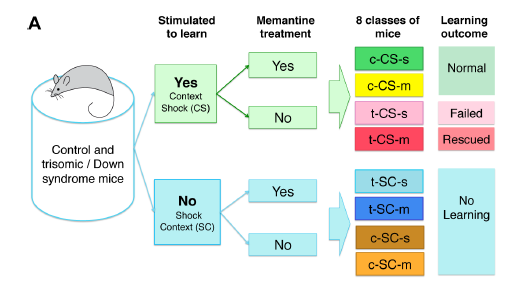

<a id='section_2'></a>
## 2. Exploratory Data Analysis

In [ ]:
import numpy as np
import math
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.multitest as multi
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from pandas.plotting import parallel_coordinates

First of all we import the dataset. Most notably we convert the class variable as categorical. Then we create a dataset with all the possible categories as features because it may be useful. Also we prepare the data for the classification and we create a dictionary that will allow us to decode the numeric labels given to the classes. 

In [ ]:
# Read the data and creates a pandas DataFrame

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train['class'] = pd.Categorical(train['class'])
test['class'] = pd.Categorical(test['class'])
# Print the first few raws of the dataset
print(train.shape)
print(test.shape)

# how to deal with missing SOD1_n feature in test data??
# -> remove it from training if not really important
# -> other ideas

full_train = train.copy()
full_train['learn_stim'] = np.where(full_train['class'].str.contains('CS'), 1, 0)
# 1 = context shock 0 = Shock Context
full_train['memantine'] = np.where(full_train['class'].str.contains('m'), 1, 0) 
# 1 = memantine 0 = saline
full_train['status'] = np.where(full_train['class'].str.contains('t'), 1, 0)
# 1 = trisomic 0 = control
def label_learning (row):
    if row['class'] in (['c-CS-m','c-CS-s']) :
        return 'Normal'
    if row['class'] in (['t-CS-s']) :
        return 'Failed'
    if row['class'] in (['t-CS-m']) :
        return 'Rescued'
    if row['class'] in (['t-SC-m','t-SC-s','c-SC-m','c-SC-s']) :
        return 'No'

full_train['actual_learning'] = full_train.apply(
    lambda row: label_learning(row), axis=1)
    
# scikit api datasets

X = np.array( train.drop('class', axis=1)) #the floating point values
y = np.array(train['class'].cat.codes) #unsigned integers specifying group
y_cat = np.array(train['class'])


label_dict = { np.unique(y)[k] : np.unique(y_cat)[k] 
              for k in range(len(np.unique(y_cat)))}

train2 = train.drop("SOD1_N", axis=1)
X_2 = np.array(train2.drop('class', axis=1))
y_2 = np.array(train2['class'].cat.codes) #unsigned integers specifying group
y_2_cat = np.array(train2['class'])

X_test = np.array(test.drop('class', axis=1))
y_test = np.array(test['class'].cat.codes)
y_test_cat = np.array(test['class'])
# print(X_2.shape)
# print(y_2.shape)

In [ ]:
full_train.iloc[:,-5:]

We check how many samples per class we have, in order to see if the classes are balanced or not.
<a id='fig2.1'></a>
#### Fig. 2.1

In [ ]:
train.groupby('class').size().plot(kind='bar')
plt.show()

The classes are slightly unbalanced, however this unbalance does not seem so important so it shouldn't be a concern for our classification purposes.
<a id='fig2.2'></a>
#### Fig. 2.2

In [ ]:
sns.violinplot(x="class", y="SOD1_N", data=train, palette="Pastel1")
plt.show()

Then we check the distribution of a protein in the different classes. In this case we chose SOD1 because it's the missing protein in our test data. This protein expression varies a lot especially between CS and SC classes. However visualizing all the 77 features like this is unfeasible so we opted for a parallel coordinates plot.
<a id='fig2.3'></a>
#### Fig. 2.3

In [ ]:
# In case you would want to order it

# order = train_mean.mean().sort_values()
# order = order.index.tolist()
# order.append("class")
# train_mean = train_mean[order]
# train = train[order]

# Perform parallel coordinate plot
#15,10
fig, (ax1,ax2) = plt.subplots(2, figsize=(15,15))
plt.grid(b=None)
parallel_coordinates(train, 'class',colormap=plt.get_cmap("Set1"), ax=ax1)
ax1.set_xticks([])
handles, labels = ax1.get_legend_handles_labels()
labels
ax1.set_title('Parallel coordinates plot')
ax1.set_ylabel('Exp')
train_mean_class = train.groupby('class').mean()
train_mean_class = train_mean_class.reindex(labels)
train_mean_class = train_mean_class.reset_index()

ax2.set_title('Parallel coordinates plot of the means')
ax1.set_ylabel('Mean Exp')

parallel_coordinates(train_mean_class, 'class',
                     colormap=plt.get_cmap("Set1"), ax=ax2)
plt.xticks(rotation=90)

plt.show()

In this plot we can see the different behaviour of the proteins in the different classes. Some proteins vary a lot and some are quite stable. Also there is a big difference in the values of expression between proteins. This may suggest that some sort of normalization may be needed in succesive analysis. However this plot is not perfectly clear so we opted for a more interpretable dotplot.
<a id='fig2.4'></a>
#### Fig. 2.4

In [ ]:
train_mean = train.mean() 
train_mean.sort_values(inplace=True)

train_mean_class = train.groupby('class').mean()
train_mean_class = train_mean_class.T
train_mean_class = train_mean_class.reindex(index=train_mean.index)

train_std = train.std()
train_std.sort_values(inplace=True)

train_std_class = train.groupby('class').std()
train_std_class = train_std_class.T
train_std_class = train_std_class.reindex(index=train_std.index)

train_std=train_std.reindex(index=train_mean_class.index)
train_std_class = train_std_class.reindex(index=train_std.index)

# Draw plot

fig, (ax1,ax2,ax3,ax4) = plt.subplots(ncols=4, figsize=(15,15))

ax1.hlines(y=train_mean.index, xmin = 0,xmax = 5.1,color='gray', alpha=0.7, linewidth=1, linestyles='dashdot')
ax1.scatter(y=train_mean.index, x=train_mean.values, s=65,c=train_mean.values, cmap='Reds', alpha=0.7)

# Title, Label, Ticks and Ylim
ax1.set_title('Dot Plot for Protein Mean', fontdict={'size':14})
ax1.set_xlabel('Mean')
ax1.tick_params(axis='y', which='major', labelsize=9)
ax2.hlines(y=train_mean_class.index, xmin = 0,xmax = 5.1,color='gray', alpha=0.5, linewidth=1, linestyles='dashdot')
for idx, val in enumerate(list(train_mean_class.columns)):
    ax2.scatter(y=train_mean_class.index, x=train_mean_class.values[:,idx], s=40, alpha=0.7, label  = val)
#lgnd = ax2.legend( bbox_to_anchor=(0.9,0.25))
#for handle in lgnd.legendHandles:
#    handle.set_sizes([50])
ax2.set_title('Protein Mean divided by class', fontdict={'size':14})
ax2.set_xlabel('Mean')
ax2.set_yticks([])

ax3.hlines(y=train_std.index, xmin = 0,xmax = 1.65,color='gray', alpha=0.7, linewidth=1, linestyles='dashdot')
ax3.scatter(y=train_std.index, x=train_std.values, s=65,c=train_std.values, cmap='Reds', alpha=0.7)

# Title, Label, Ticks and Ylim
ax3.set_title('Dot Plot for Protein Sd', fontdict={'size':14})
ax3.set_xlabel('Sd')
ax3.set_yticks([])
ax3.tick_params(axis='y', which='major', labelsize=9)

ax4.hlines(y=train_std_class.index, xmin = 0,xmax = 1.65,color='gray', alpha=0.5, linewidth=1, linestyles='dashdot')
for idx, val in enumerate(list(train_std_class.columns)):
    ax4.scatter(y=train_std_class.index, x=train_std_class.values[:,idx], s=40, alpha=0.7, label  = val)
lgnd = ax4.legend( bbox_to_anchor=(0.9,0.25))
for handle in lgnd.legendHandles:
    handle.set_sizes([50])
ax4.annotate('SOD1 is an\nimportant protein!',
            color="firebrick",
            xy=(0.36, 47), xycoords='data',
            xytext=(30, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"))
ax4.set_title('Protein Sd divided by class', fontdict={'size':14})
ax4.set_xlabel('Sd')
ax4.set_yticks([])

plt.show()

From this plot we can see the mean and the standard deviation of all the proteins in the 8 different classes. Many proteins have low mean expression value with low variation between classes, however the supposedly informative proteins (essentially the ones with great variation) are quite easily recognizable. It also shows that the expressionn values are on quite different ranges with most of the proteins between 0-1 and few between 1-5, this suggests that we should normalize our data before the clustering. SOD1 appears to be a very important protein, it varies much more than the majority of proteins with similar expression values especially between CS and SC classes as seen in [(vd Fig 2.2.)](#fig2.2)

Then we explored correlation between all features to explore if there were some evident patterns and to check if multicollinearity may be a problem.
<a id='fig2.5'></a>
#### Fig.2.5

In [ ]:
# heatmap for feature correlation
X_df = train.drop('class', axis=1)
corr_df = X_df.corr()
#sns.heatmap(corr_df)
fig, ax = plt.subplots(figsize=(17,17)) 

cax = ax.matshow(corr_df,cmap='RdYlGn_r', vmin=-1, vmax=1)
fig.colorbar(cax,fraction=0.046, pad=0.04)
ticks = np.arange(0,len(X_df.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(X_df.columns)
ax.set_yticklabels(X_df.columns)
plt.show()

There are few correlated features, mostly positively especially DYRK1A, NR1, NR2A, pELK, pERK, ELK, ERK. SOD1 seems negatively correlated with few proteins. Sorting the matrix by the mean expression value may be a good idea.
<a id='fig2.6'></a>
#### Fig. 2.6

In [ ]:
corr_df_ordered = corr_df.reindex(index = train_mean.index)
corr_df_ordered = corr_df_ordered[list(train_mean.index)]

fig, ax = plt.subplots(figsize=(17,17)) 

cax = ax.matshow(corr_df_ordered,cmap='RdYlGn_r', vmin=-1, vmax=1)
fig.colorbar(cax,fraction=0.046, pad=0.04)
ticks = np.arange(0,len(corr_df_ordered.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(corr_df_ordered.columns)
ax.set_yticklabels(corr_df_ordered.columns)
plt.show()

This figure shows how proteins with high expression values (lower rows and right columns) tend to be higly correlated with each other. Whereas proteins with lower expression (higher rows and left columns) tend to be uncorrelated except BAX and NUMB. 
<a id='fig2.7'></a>
#### Fig. 2.7

In [ ]:
TC = train[list(train_mean.index)+['class']].groupby('class')

corr_classes=TC.corr()

fig,axn = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(20, 10))#fig.subplots_adjust(hspace=0.4, wspace=0.4)

cbar_ax = fig.add_axes([.92, 0.13, .03, .75])

i=1
for a,b in TC:
    ax = plt.subplot(2, 4, i)
    if i == 8:
        sns.heatmap(corr_classes.loc[a], cmap='RdYlGn_r',vmin=-1, vmax=1,cbar=True,cbar_ax = cbar_ax,  
                    xticklabels=False, yticklabels=False, ax=ax)
    else:
        sns.heatmap(corr_classes.loc[a], cmap='RdYlGn_r',vmin=-1, vmax=1,cbar=False, xticklabels=False, 
                    yticklabels=False, ax=ax)
    ax.set_title(a, fontdict={'size':10})
    i=i+1
        #plt.tight_layout()


We can see that the correlation  patterns is quite consistent between the classes. It appears 'weaker' in t-SC-m and 'stronger' in t-SC-s.

<a id='tab2.1'></a>
#### Tab 2.1

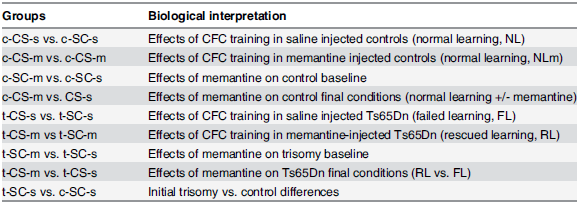

Then, as done in the paper, we tried to identify those proteins with significantly different levels between two classes. We used the same approach of the authors. First we decided the meaningful comparisons, shown in [Tab 2.1.](#tab2.1) with their biological interpretation. Then we performed for each protein a Wilcoxon test comparing the values of one class vs another class. This means 77 proteins * 8 comparsions = 616 tests. As a result we obtained a list of proteins which significantly varies between two classes. This may be helpful to validate the clustering but also to focus the attention on a the subset of protein which appear to be discriminant. 

In [ ]:
comparisons = [['c-CS-s','c-SC-s'], ['c-CS-m','c-SC-m'],['c-SC-m','c-SC-s'],
              ['c-CS-m','c-SC-s'],['t-CS-s','t-SC-s'],['t-CS-m','t-SC-m'],
              ['t-SC-m','t-SC-s'],['t-CS-m','t-CS-s'],['t-SC-s','c-SC-s']]

sig = {}
comp = []
prot = [] 
pval = []

for idx, val in enumerate(comparisons):
    for idx2, val2 in enumerate(train.columns[:-1]):
        a = train.loc[train['class'] == val[0]][val2]
        b = train.loc[train['class'] == val[1]][val2]
        result = stats.mannwhitneyu(a,b)
        string = " vs ".join(val)
        comp.append(string)
        prot.append(val2)
        pval.append(result.pvalue)
        sig['test'] = comp
        sig['protein'] = prot
        sig['result'] = pval
#         sig.append([val,val2,result.pvalue])
# sig[0].append(['ciao','bye'])    
wilc = pd.DataFrame(sig)
#wilc.loc[wilc[protein] == 'DYRK1A_N']
wilc = wilc.pivot_table(index = 'protein',
               columns = 'test',
               values = 'result')

In [ ]:
wilc_correct = wilc.copy()
sig_dict = {}

for idx, val in enumerate (wilc_correct.columns):
    arr = multi.multipletests(wilc.loc[:,val], method='bonferroni')[1]
    # p val * 77
    col = [t for t in arr]
    wilc_correct.loc[:,val] = col
    sig_dict[val] = list(wilc_correct.loc[wilc_correct[val] < 0.05].index)

print(sig_dict)

Now sig_dict contains all the comparisons as keys and the significant proteins as values. It is important to note that the p-values were adjusted with the Bonferroni correction, the most conservative one.

This is some code to create dataframes and functions that we'll need later. Essentialy these are the dataset that we'll use perform the clustering algorithms or PCA. We also created dataset with reduced features for both only controls and only trisomic samples. The features were selected by computing the union of the sets of proteins that were previously found significant. This is done to see if the discriminant proteins are actually critical to class discrimination. 

In [ ]:
X = np.array(train.drop('class', axis=1)) #the floating point values
y = np.array(train['class'].cat.codes) #unsigned integers specifying group
y_cat = np.array(train['class'])

X_mm = MinMaxScaler().fit_transform(X)
X_std = StandardScaler().fit_transform(X)

label_dict = { np.unique(y)[k] : np.unique(y_cat)[k] for k in range(len(np.unique(y_cat)))}

In [ ]:
comp_c = ['c-CS-m vs c-SC-m','c-CS-m vs c-SC-s','c-CS-s vs c-SC-s','c-SC-m vs c-SC-s']
comp_t = ['t-CS-m vs t-CS-s','t-CS-m vs t-SC-m', 't-CS-s vs t-SC-s', 't-SC-m vs t-SC-s']
union_c = list(set(sig_dict[comp_c[0]]) | set(sig_dict[comp_c[1]]) | set(sig_dict[comp_c[2]]) | set(sig_dict[comp_c[3]]))
union_t = list(set(sig_dict[comp_t[0]]) | set(sig_dict[comp_t[1]]) | set(sig_dict[comp_t[2]]) | set(sig_dict[comp_t[3]]))

full_train_c = full_train[full_train.status==0]

df_c_red = full_train_c[union_c]
df_c = full_train_c[train.drop('class', axis=1).columns]

full_train_t = full_train[full_train.status==1]
df_t_red = full_train_t[union_t]
df_t = full_train_t[train.drop('class', axis=1).columns]

X_c = MinMaxScaler().fit_transform(np.array(df_c)) #the floating point values
y_c = np.array(full_train_c['class'].cat.codes) #unsigned integers specifying group
#plot_pca3d(X_c, y_c)
y_c_cat = np.array(full_train_c['class'])
label_dict_c = { np.unique(y_c)[k] : np.unique(y_c_cat)[k] for k in range(len(np.unique(y_c_cat)))}

X_t = MinMaxScaler().fit_transform(np.array(df_t)) #the floating point values
y_t = np.array(full_train_t['class'].cat.codes) #unsigned integers specifying group
#plot_pca3d(X_c, y_c)
y_t_cat = np.array(full_train_t['class'])
label_dict_t = { np.unique(y_t)[k] : np.unique(y_t_cat)[k] for k in range(len(np.unique(y_t_cat)))}

X_c_red = MinMaxScaler().fit_transform(np.array(df_c_red)) #the floating point values
X_t_red = MinMaxScaler().fit_transform(np.array(df_t_red)) #the floating point values

full_train_CS = full_train[full_train.learn_stim==1]
df_CS = full_train_CS[train.drop('class', axis=1).columns]
X_CS = MinMaxScaler().fit_transform(np.array(df_CS))
y_CS = np.array(full_train_CS['class'].cat.codes) #unsigned integers specifying group
#plot_pca3d(X_c, y_c)
y_CS_cat = np.array(full_train_CS['class'])
label_dict_CS = { np.unique(y_CS)[k] : np.unique(y_CS_cat)[k] for k in range(len(np.unique(y_CS_cat)))}


full_train_SC = full_train[full_train.learn_stim==0]
df_SC = full_train_SC[train.drop('class', axis=1).columns]
X_SC = MinMaxScaler().fit_transform(np.array(df_SC))
y_SC = np.array(full_train_SC['class'].cat.codes) #unsigned integers specifying group
#plot_pca3d(X_c, y_c)
y_SC_cat = np.array(full_train_SC['class'])
label_dict_SC = { np.unique(y_SC)[k] : np.unique(y_SC_cat)[k] for k in range(len(np.unique(y_SC_cat)))}

In [ ]:
def pca_varexp(X, title):
    pca = PCA().fit(X)
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.title(title)
    major_ticks = np.arange(0, X.shape[1], 10)
    minor_ticks = np.arange(0, X.shape[1], 1)
    ax.set_xticks(major_ticks)
    ax.set_ylim([0,1])
    ax.set_xticks(minor_ticks, minor=True)
    plt.grid()
    plt.show()
    
def plot_pca2d(X, y_cat,title):
    pca2 = PCA(n_components=2)  # project from 76 to 2 dimensions
    projected2 = pca2.fit_transform(X)

    fig = plt.figure(figsize=(10,5))
    sns.scatterplot(projected2[:, 0], projected2[:, 1], hue=y_cat, edgecolor='k',
                    palette=sns.color_palette("Set2", n_colors=np.unique(y_cat).shape[0]))
    plt.xlabel('PC 1 (%.2f%%)' % (pca2.explained_variance_ratio_[0]*100))
    plt.ylabel('PC 2 (%.2f%%)' % (pca2.explained_variance_ratio_[1]*100))
    plt.title(title)
    plt.show()    

def plot_pca3d(X, y, df,title):
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(10, 10), dpi=96)
    ax = fig.add_subplot(111, projection='3d')

    pca = PCA(n_components=3)
    pca.fit(X)
    X_trans = pca.transform(X)

    labelTups = list(zip(list(y),list(df['class'])))
    labelTups = list(set(labelTups))
    label_dict = {item[0]: item[1] for item in labelTups}

    sc = ax.scatter(X_trans[:, 0], X_trans[:, 1], X_trans[:, 2], c=y, 
                    cmap=plt.cm.get_cmap("Set2"), edgecolor='k', s=130)

    result=pd.DataFrame(X_trans, columns=['PCA%i' % i for i in range(3)], 
                        index=df.index)

    colors = [sc.cmap(sc.norm(i)) for i in [t[0] for t in labelTups]]
    custom_lines = [plt.Line2D([],[], ls="", marker='.', 
                    mec='k', mfc=c, mew=.1, ms=20) for c in colors]
    ax.legend(custom_lines, [lt[1] for lt in labelTups], 
              loc='center left', bbox_to_anchor=(1.0, .5))

    xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
    ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
    yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
    ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
    zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
    ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

    # ax.text(x=0.74048959,y=-1.85937686,z=1.64074746,s= 'ciao')
    #  to check if correct color-legend assignment
    # label the axes
    ax.set_xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100))
    ax.set_ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100))
    ax.set_zlabel('PC 3 (%.2f%%)' % (pca.explained_variance_ratio_[2]*100))
    ax.set_title(title)
    plt.show()

We performed PCA to check how much variance is explained by the principal components. We did this on the original data, on Min-Max scaled data and on the standardized data. Prior to PCA it's important to normalize especially when there are features measured with different scales. This is done to avoid giving too much importance to variables that have higher variance only because of their specific scale. Even though all the features here are measured in the same assay with the same units normalizing may still be a good idea given that the ranges of protein expression are so different. The authors of the paper opted for min-max scaling, which basically 'shrink' all your estimates in the interval 0,1. Here, the original data were also standardized, which means centering the mean at 0 and fixing the variance at 1. 

<a id='fig2.8'></a>
#### Fig. 2.8

In [ ]:
pca_varexp(X, "PCA")
pca_varexp(X_mm, "PCA on scaled values (minmax)")
pca_varexp(X_std, "PCA on standardized values (standardized)")

We can see that for the PCA on raw data the first few components explain most of the variability of the data. This is due to the fact that without normalization proteins with higher expression values, and with higher variance, will have more importance than the other features in lower ranges. This causes the 1st PC to explain 35 % of the variance, all the samples would be stretched along this main axis. 

Normalizing the data avoids this phenomenon and we can see that the proportion of variance explained increase much more slowly. The two different normalizations seem to behave in a similar manner.

The subsequent analyses were performed on Min-Max scaled data because they produced good results and to keep reproducibility with the paper (even though how you standardize your data should not cause any significant difference).

<a id='fig2.9'></a>
#### Fig. 2.9

In [ ]:
plot_pca2d(X, y_cat, "PCA")
plot_pca3d(X, y, train, "PCA")

We can see that not normalized data stretch along the main axis and they don't appear to be clearly clustered.

<a id='fig2.10'></a>
#### Fig. 2.10

In [ ]:
plot_pca2d(X_mm, y_cat, "PCA")
plot_pca3d(X_mm, y, train, "PCA")

Even though the variance explained by the first 3 axis is much less, the minmax scaled data appear to be clustered in two main groups divided along the 2nd axis. These groups are mainly represened by the SC and CS samples. This plot can be made interactive if %matplotlib notebook is added in the script (it does not always work however).

As done in the paper these analyses were also performed on only control samples and only trisomic samples.
<a id='fig2.11'></a>
#### Fig. 2.11

In [ ]:
#%matplotlib notebook 
#-> make it interactive
#%matplotlib inline 
#-> make it static

plot_pca2d(X_c, y_c_cat,"PCA on only control samples")
plot_pca2d(X_c_red, y_c_cat,"PCA on only control samples on selected features n=23")
plot_pca3d(X_c,y_c,full_train_c,"PCA on control cases")
plot_pca3d(X_c_red,y_c,full_train_c, "PCA on control cases and selected features")

The control samples seems to be clearly spearated between those who learn (CS) and those who doesn't (SC). This confirms the paper findings that learning in controls seems to be associated with a different level of expression. 
<a id='fig2.12'></a>
#### Fig. 2.12

In [ ]:
plot_pca2d(X_t, y_t_cat,"PCA on only trisomic samples")
plot_pca3d(X_t,y_t,full_train_t, "PCA on trisomic cases")
plot_pca2d(X_t_red, y_t_cat,"PCA on only trisomic samples on selected features n=23")
plot_pca3d(X_t_red,y_t,full_train_t, title="PCA on trisomic cases and selected features")

Trisomic samples show more or less the same behaviour. The CS and SC classes are clearly separated. In this case the most interesting class is t-CS-s because they fail to learn. Supposedly, given the seemingly importance of learning, they should be closer to SC samples. This tendency however it's not clearly observed here. It can be argued that the main factor may not be learning but fear. \
The same can be done for exclusively SC and CS classes.

In [ ]:
plot_pca2d(X_CS, y_CS_cat, "PCA on CS")
plot_pca3d(X_CS, y_CS, full_train_CS,"PCA on CS")
plot_pca2d(X_SC, y_SC_cat, "PCA on SC")
plot_pca3d(X_SC, y_SC, full_train_SC,"PCA on SC")

As expected, the groupings are not so defined, we have seen that the differences are mainly between SC and CS and not within.
<a id='section_3'></a>
# 3. Clustering

Clustering is generally used to find important structures or analyze groupings in the data. This could help us discover features and properties that characterize the dataset and the different groups. Usually, clustering is an unsupervised machine learning method, which means that the input data do not have an associated label. However, in our case, the data are labelled so, it will be much easier to assess the quality of the results of a clustering algorithm. In fact, we can use the label information to check if the cluster are homogenous and in agreement with the data.

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import pairwise_distances

<a id='section_3.1'></a>
### Agglomerative hierarchical clustering

Agglomerative hierarchical clustering is a clustering algorithm that builds clusters by merging groups succesively based on a distance measure. This process is reiterated until all clusters have been merged into one unique cluster. For this reason, this approach is also called bottom-up. The hierarchy of clusters is represented by a tree. The root is the unique big cluster and the tips are the single samples.

Intuitively, the hierachical clustering perfomance should be pretty accurate as the different classes are somehow hierarchically related among each others. Indeed, the classes are characterized by different combinations of syndrome, stimulation and injection. It will be expected that this structure will emerge in the hierarchical clustering.

These are some functions that will help us visualize and evaluate the quality of the final clustering

In [ ]:
def plot_dendrogram(Z=None, model=None, X=None, **kwargs):
    annotate_above = kwargs.pop('annotate_above', 0)

    # Reconstruct the linakge matrix if the standard model API was used
    if Z is None:
        if hasattr(model, 'distances_') and model.distances_ is not None:
            # create the counts of samples under each node
            counts = np.zeros(model.children_.shape[0])
            n_samples = len(model.labels_)
            for i, merge in enumerate(model.children_):
                current_count = 0
                for child_idx in merge:
                    if child_idx < n_samples:
                        current_count += 1  # leaf node
                    else:
                        current_count += counts[child_idx - n_samples]
                counts[i] = current_count

            Z = np.column_stack([model.children_, model.distances_,
                                              counts]).astype(float)
        else:
            Z = linkage(X, method=model.linkage, metric=model.affinity)
    
    if 'n_clusters' in kwargs:
        n_clusters = kwargs.pop('n_clusters')
        # Set the cut point just above the last but 'n_clusters' merge
        kwargs['color_threshold'] = Z[-n_clusters, 2] + 1e-6
    
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    # Plot the corresponding dendrogram
    ddata = dendrogram(Z, ax=ax, **kwargs) 
    
    # Annotate nodes in the dendrogram
    for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
        x = 0.5 * sum(i[1:3])
        y = d[1]
        nid = np.where(Z[:,2] == y)[0][0]
        if y > annotate_above:
            plt.plot(x, y, 'o', c=c)
            plt.annotate(str(nid-Z.shape[0]), (x, y), xytext=(0, -5),
                         textcoords='offset points',
                         va='top', ha='center')
    if kwargs['color_threshold']:
        plt.axhline(y=kwargs['color_threshold'], c='k')
    
    return fig, ax

def get_node_leaves(Z, idx, N):
    n1, n2 = Z[idx,0], Z[idx,1]
    leaves = []
    for n in [n1, n2]:
        leaves += [int(n)] if n < N else get_node_leaves(Z, int(n-N), N)
    return leaves

def get_node(Z, X, y, idx, dic):
    title = str(idx)
    leaves = get_node_leaves(Z, idx, X.shape[0])
    labels, counts = np.unique(y[leaves], return_counts=True)
    labels_cat = [dic[i] for i in labels]
    count_abs = np.unique(y, return_counts=True)
    nleaves = len(leaves)
    freq = []
    for idx, val in enumerate(counts):
        index = np.where(labels[idx]==count_abs[0])
        fr = val/count_abs[1][index]
        freq.append(float(fr))
    freq = np.array(freq)
#   print(np.concatenate(np.array(counts).reshape(1,-1), freq))
    print(pd.DataFrame([counts,freq], 
                       columns=labels_cat, index=["Count:","Frequency:"]))
    print("Samples in the cluster:", len(leaves), "/", X.shape[0])
    y_pos = np.arange(len(labels_cat))
    plt.bar(y_pos, counts)
    plt.ylim(0,50)
    plt.title(title)
    plt.xticks(y_pos, labels_cat)
    plt.show()

def plot_clust_2d(X, y_cat, y_predict,title):
    pca2 = PCA(n_components=2)  # project from 76 to 2 dimensions
    projected2 = pca2.fit_transform(X)    
    fig = plt.figure(figsize=(10,5))
    
    sns.scatterplot(projected2[:, 0], projected2[:, 1], hue=y_cat, edgecolor='k', style=y_predict,
                    palette=sns.color_palette("Set2", n_colors=np.unique(y_cat).shape[0]))
    plt.xlabel('PC 1 (%.2f%%)' % (pca2.explained_variance_ratio_[0]*100))
    plt.ylabel('PC 2 (%.2f%%)' % (pca2.explained_variance_ratio_[1]*100))
    plt.title(title)
    plt.show()
    
def plot_clust_3d(X, y, df, y_predict, title):
    
    fig = plt.figure(figsize=(10, 10), dpi=96)
    ax = fig.add_subplot(111, projection='3d')
    used = set()
    uniq = [x for x in y if x not in used and (used.add(x) or True)]
    colors = sns.color_palette("Set2", n_colors=8).as_hex()
    col_legend = [colors[i] for i in uniq]
    markers = [".","v","s","*", "X","p","d","^"]
    
    pca = PCA(n_components=3)
    pca.fit(X)
    X_trans = pca.transform(X)
    
    used2 = set()
    labelTups = list(zip(list(y),list(df['class'])))
    labelTups = [x for x in labelTups if x not in used2 and (used2.add(x) or True)]
    #labelTups = list(set(labelTups))
    #label_dict = {item[0]: item[1] for item in labelTups}

    for i in range(len(X_trans)):
        ax.scatter(X_trans[i, 0], X_trans[i, 1], X_trans[i, 2], c=colors[y[i]],
                   marker=markers[y_predict[i]],
                   edgecolor='k', s=130)


    result=pd.DataFrame(X_trans, columns=['PCA%i' % i for i in range(3)], 
                        index=df.index)

    custom_lines = [plt.Line2D([],[], ls="", marker='.', 
                    mec='k', mfc=c, mew=.1, ms=20) for c in col_legend]
    ax.legend(custom_lines, [lt[1] for lt in labelTups], 
              loc='center left', bbox_to_anchor=(1.0, .5))

    xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
    ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
    yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
    ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
    zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
    ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

    # ax.text(x=0.74048959,y=-1.85937686,z=1.64074746,s= 'ciao')
    #  to check if correct color-legend assignment
    # label the axes
    ax.set_xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100))
    ax.set_ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100))
    ax.set_zlabel('PC 3 (%.2f%%)' % (pca.explained_variance_ratio_[2]*100))
    ax.set_title(title)
    plt.show()
    
def plot_cm(labels_true, labels_pred, labels_dict):
    cm = contingency_matrix( labels_true = labels_true, labels_pred = labels_pred)
    fig, ax = plt.subplots(figsize=(6,6))
    plt.imshow(cm,interpolation='none',cmap='summer_r')
    for (i, j), z in np.ndenumerate(cm):
        plt.text(j, i, z, ha='center', va='center')
    ax.set_yticks(range(len(list(labels_dict.keys()))))
    ax.set_yticklabels(list(labels_dict.values()))
    plt.xlabel("hclust label")
    plt.ylabel("truth label")
    plt.show()

def incidence_mat(y_pred):
    npoints = y_pred.shape[0]
    mat = np.zeros([npoints, npoints])
    # Retrieve how many different cluster ids there are
    clusters = np.unique(y_pred)
    nclusters = clusters.shape[0]
    
    for i in range(nclusters):
        sample_idx = np.where(y_pred == i)
        # Compute combinations of these indices
        idx = np.meshgrid(sample_idx, sample_idx)
        mat[idx[0].reshape(-1), idx[1].reshape(-1)] = 1
        
    return mat

def similarity_mat(X, metric):
    dist_mat = pairwise_distances(X, metric=metric)
    min_dist, max_dist = dist_mat.min(), dist_mat.max()
    sim_mat = 1 - (dist_mat - min_dist) / (max_dist - min_dist)
    return sim_mat

def correlation(X, y_pred, metric):
    inc = incidence_mat(y_pred)
    sim = similarity_mat(X, metric)
    
    # Note: we can eventually remove duplicate values
    # only the upper/lower triangular matrix
    # triuidx = np.triu_indices(y_pred.shape[0], k=1)
    # inc = inc[triuidx]
    # sim = sim[triuidx]
    
    inc = normalize(inc.reshape(1, -1))
    sim = normalize(sim.reshape(1, -1))
    corr = (inc @ sim.T)
    return corr[0,0]   

def sorted_sim(sim, y_pred):
    idx_sorted = np.argsort(y_pred)
    # Sort the rows
    sim = sim[idx_sorted]
    # Sort the columns
    sim = sim[:, idx_sorted]
    
    return sim

def plot_sorted_sim(sim, y_pred):
    sim = sorted_sim(sim, y_pred)
    
    fig, ax = plt.subplots(figsize=(12,8))  
    ax = sns.heatmap(sim, ax=ax,cmap='RdYlGn_r')
    # Remove ruler (ticks)
    ax.set_yticks([]) 
    ax.set_xticks([])
    plt.show()

Agglomerative hierarchical clustering performance depends on two decisions. One is the metric used to define distances between two data points. The other is the linkage criteria. This determines the way the clusters are merged together. There are 5 basic alternatives:

1. **Single** linkage minimizes distance between closest observations of pairs of clusters
2. **Average** linkage minimizes the average of distances between observations of pairs of clusters 
3. **Maximum** linkage minimizes the maximum distance between observations of pairs of clusters
4. **Centroid** linkage minimizes the distance between centroids of pairs of clusters
5. **Ward** linkage minimizes the total within-cluster variance

Each linkage has different properties and its efficacy depends on the data. Single linkage is very efficient and can handle non-elliptical shapes but is quite sensitive to noise and outliers. Whereas complete linkage is more robust to noise but it's biased to globular shapes. Centroid linkage may suffer inversions. Ward is generally very stable.

Here, all 5 linkage methods are tested on the data to understand which one might work better. Note that the euclidean distance is used. We assume that with other metrics the result would be comparable.

<a id='fig3.1'></a>
#### Fig. 3.1

In [ ]:
methods = ['single', 'average', 'complete', 'centroid', 'ward']

for method in methods:
    Z = linkage(X_mm, metric='euclidean', method=method)
    fig, ax = plot_dendrogram(Z=Z, X=X_mm, truncate_mode='lastp', 
                              p=100, n_clusters=10)
    ax.set_title(method)

- **Single** linkage is the one that provides smaller jumps among all. The dendrogram produce is not good at all in our case
- **Average** linkage as single linkage has very little jumps between clusters
- **Complete** linkage seems quite good
- **Centroids** linkage dednrogram is similar to the single linkage one and there are some inversions 
- **Ward** linkage seems like a reasonable dendrogram

From now on we decide to use Ward linkage method because it seems to produce the best dendrogram. For this reason we also use Euclidean distance which is the only one supported by this method.

Now we explore in more detail the chosen denrogram. We can see the distibution of classes in a certain node, using a function defined before, and we can use some tpical clustering metrics.

<a id='fig3.2'></a>
#### Fig. 3.2

In [ ]:
# Generate the linkage matrix
Z = linkage(X_mm, metric='euclidean', method='ward')
plot_dendrogram(Z=Z, X=X_mm,truncate_mode='lastp', 
                p=50, n_clusters=8)

In [ ]:
get_node(Z,X_mm,y, -10, label_dict)
get_node(Z,X_mm,y, -8, label_dict)
get_node(Z,X_mm,y, -27, label_dict)
get_node(Z,X_mm,y, -34, label_dict)
get_node(Z,X_mm,y, -9, label_dict)
get_node(Z,X_mm,y, -11, label_dict)
get_node(Z,X_mm,y, -21, label_dict)
get_node(Z,X_mm,y, -12, label_dict)

These barplots can help us understand what is the distibution, the frequency and the count of the classes inside a specific node of the tree. 

Starting from the two biggest clusters (the **bold** ones are the final 8 clusters): 
- *Cluster -4*: This cluster contains all the CS classes
    - **Cluster -10**: same as parent node
    - **Cluster -8**: same as parent node with majority of t-CS
- *Cluster -2*: This cluster contains all classes but comprise 100% of the SC with 5/137 CS
    - *Cluster -5*: contains the majority of SC, only t-SC-s is only 50%
        - **Cluster -27** contains only few SC samples with more t than c
        - **Cluster -34**: contains few t-SC samples
        - **Cluster -9**: contains almost all c-SC samples with half of the t-SC samples and 3 CS exceptions
    - *Cluster -3*: contains more than half of the CS classes and 43% of t-CS-m, the other SC classes are only few excpetions
        - **Cluster -11**: contains samples from all classes, this cluster is quite noisy
        - **Cluster -21**: as before
        - **Cluster -12**: this node is represented by mostly cs samples but it's not so homogenous
        
This clustering is satisfying when analysing the distionction between SC and CS classes. Indeed, these two groups are quite clearly differentiated. Differently, it's hard to spot distinctions among the influence of the injection and the karyotype.

Agglomerative hierarchical clustering can also be done using scikit API. \
Using one of the functions previously defined we visually analise the clustering on PCA reduced dimensions, assigning to each point the color based on its true label and the shape based on its predicted one.

<a id='fig3.2'></a>
#### Fig. 3.2

In [ ]:
distance_threshold=None#270
n_clusters=8

model = AgglomerativeClustering(n_clusters=n_clusters, 
                                distance_threshold=distance_threshold, 
                                affinity='euclidean', linkage='ward')

y_predict = model.fit_predict(X_mm)
plot_clust_3d(X_mm, y, train,y_predict, "PCA")
plot_clust_2d(X_mm, y_cat, y_predict, "PCA")

Analyzing these plots, it can be noticed that the distinction between the CS and SC clusters can be visually spotted. For instance, in the 2-dimentional plot, the rhombus and the circle almost completely correspond to the CS label, and hence represent clusters 10 and 8.

In order to quantitatively evaluate the quality of the clusters and clustering, different measures have been used.

1. Using true label information:

    **Adjusted random index**

    the adjusted Rand index is a function that measures the similarity between the true labels and the predicted ones. Perfect is 1, negative measures are bad and 0 means random label assignments. No assumption is made on the cluster structure.

    **V-measure**
    
    Harmonic mean between homogeneity (each cluster with members of just one class) and completeness (proportional to qunatity of members of class in same cluster). 0 is the worst and 1 is perfect.
    
    **Fowlkes-Mallows score**
    
    this index is the geometric mean between the pairwise precision and recall. It ranges from 0 to 1. 1 is perfect.
    
    **Contingency matrix**
    
    this matrix represent the intersection between the true labels and the predicted ones. It is an useful way to quickly visualize the efficacy of a clustering algorithm if the classes are few.
    

2. Properly unsupervised:

    **Silhouette**:
     in these cases evaluation must be performed using the model itself. A higher Silhouette Coefficient score relates to a model with better defined clusters. The Silhouette Coefficient is defined for each sample and is composed of two scores:
    
    a: The mean distance between a sample and all other points in the same class.

    b: The mean distance between a sample and all other points in the next nearest cluster.
    
    This index then describe both the within cluster and between cluster similarity.
    
    **Sorted similarity matrix**
    
    After computing the similarity matrix between all pairs of samples it is possible to sort it by the predicted label. If the clustering is good there will be more similar blocks on the diagonal and dissimilar blocks off the diagonal.

For other info check the [scikit page](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)

<a id='fig3.3'></a>
#### Fig. 3.3

In [ ]:
labels = model.labels_
print("Silhouette score: ",round(metrics.silhouette_score(X_mm, labels, metric='euclidean'),4))
print("Adj Rand Index: ",round(metrics.adjusted_rand_score(y, labels),4))
print("V-measure: ",round(metrics.v_measure_score(y, labels),4))
print("Fowlkes-Mallows index: ",round(metrics.fowlkes_mallows_score(y, labels),4))

print("CONTINGENCY MATRIX:")
plot_cm(y, labels, label_dict)

sim = similarity_mat(X_mm, 'euclidean')
plot_sorted_sim(sim, y_predict)

- **Silhouette Score** the score is near to zero. This means that the clusters overlap. This is actually coherent with our findings, as the different labels corresponding to the injection and karyotype were not recognized. Thus, they were ovverlapping. The reason why this score is not too high might also rely behind the fact that the silhoutte score is generally higher when the clusters are convex, and this is not the case.
- **ARI** should perform relatively good, as no assumption is made on the clusters. Even though the absolute value of this score is low, it is positive. Thus, they are similar clusterings.
- **V-measure** This measure is mediocre showing that cluster are not so homogenoues nor complete.
- **Fowlkes-Mallows index** according to this index, he clustering does not perform very accurately this is because, as we can see from the contingency matrix, the clustering is quite accurat on finding CS or SC classes but not the more specific ones. Therefore, Accuracy and recall will be quite low.

The contingency matrix is coerent with the comments that were previously made regarding the subdivision of CS and SC classes.

The Similarity matrix emphasizes the fact that the found clusters are not well-defined. Indeed, the score measures were not very promising. From the plot, it can be noticed that the squares plotted on the diagonal of the bigger square are not very ditinct when compared to the 'background'.

Now, the hierarchical clustering is done on a different dataset. Indeed, only the control label will be analysed and subject to clustering. This has been done in order to reproduce the paper analysis. Of course, since only half of the original labels are taken into consideration, the number of clusters will be 4 and not 8 anymore.\
What we are hoping to obtain from  this second clustering, is a distinct subdivision of the data point in 4 of the 8 possible classes (c-CS-m, c-CS-t, c-SC-m, c-SC-t). We are expecting that there will be a first big subdivision among c-CS and c-SC.

<a id='fig3.4'></a>
#### Fig. 3.4

In [ ]:
Z_c = linkage(X_c, metric='euclidean', method='ward')
plot_dendrogram(Z=Z_c, X=X_c,truncate_mode='lastp', 
                p=50, n_clusters=4)

Analysing the diagrams of the different nodes that follow, we get to the follwing results.\
Most of the data points belonging to the CS classes are included in the clusters 5 and 4. In particular, cluster 5 is characterised by points belonging only to c-CS-m and c-CS-s. Differently, it is very hard to get to conclusions regarding cluster 9, as it does not include relevant distinction among the different labels. At last, cluster 7 is characterized by data points belonging to the SC class.

In [ ]:
print(get_node(Z_c,X_c,y_c, -5, label_dict_c))
print(get_node(Z_c,X_c,y_c, -4, label_dict_c))
print(get_node(Z_c,X_c,y_c, -9, label_dict_c))
print(get_node(Z_c,X_c,y_c, -7, label_dict_c))

<a id='fig3.5'></a>
#### Fig. 3.5

In [ ]:
model.set_params(n_clusters=4)

y_predict = model.fit_predict(X_c)

plot_clust_3d(X_c, y_c, full_train_c, y_predict, "PCA on controls with hclust")
plot_clust_2d(X_c, y_c_cat, y_predict, "PCA on controls with hclust")

labels = model.labels_
print("Silhouette score: ",round(metrics.silhouette_score(X_c, labels, metric='euclidean'),4))
print("Adj Rand Index: ",round(metrics.adjusted_rand_score(y_c, labels),4))
print("V-measure: ",round(metrics.v_measure_score(y_c, labels),4))
print("Fowlkes-Mallows index: ",round(metrics.fowlkes_mallows_score(y_c, labels),4))

print("CONTINGENCY MATRIX:")
plot_cm(y_c, labels, label_dict_c)
sim_c = similarity_mat(X_c, 'euclidean')
plot_sorted_sim(sim_c, y_predict)

In the previous plots, the characteristics of the different clusters can be analysed. For example, looking at the two-dimentional plot, the Xs represent cluster 5. Furthermore, overall, there is a clear distinctions of the clusters that describe c-SC from the ones that describe c-CS.

Compared to the previous hierarchical clustering, all of the analytical measures have improved. 

The contingency matrix shows the results that we were expecting. Two of the clusters are almost completely characterized by elements respectively from c-SC and c-CS. Furthermore, one of the clusters contains elements that are spread evenly among the different classes.

The same conclusions can be deduced from the similarity matrix. The different cluters are not extremely well defined, especially the cluster represented at the bottom right of the diagonal, which indeed represents the worst-perfroming cluster of this specific method. 

Overall, this clustering performs relatively well when defining the differences among c-CS and c-SC.

We perform the same clustering keeping only the selected proteins as features.

<a id='fig3.6'></a>
#### Fig. 3.6

In [ ]:
Z_c_red = linkage(X_c_red, metric='euclidean', method='ward')
plot_dendrogram(Z=Z_c_red, X=X_c_red,truncate_mode='lastp', 
                p=50, n_clusters=4)

In [ ]:
# print(get_node(Z_c_red,X_c_red,y_c, -7, label_dict_c))
# print(get_node(Z_c_red,X_c_red,y_c, -5, label_dict_c))
# print(get_node(Z_c_red,X_c_red,y_c, -11, label_dict_c))
# print(get_node(Z_c_red,X_c_red,y_c, -4, label_dict_c))

In [ ]:
y_predict_red = model.fit_predict(X_c_red)

plot_clust_3d(X_c_red, y_c, full_train_c, y_predict_red, "PCA on controls w/ reduced dims with hclust")
plot_clust_2d(X_c_red, y_c_cat, y_predict_red, "PCA on controls w/ reduced dims with hclust")

labels = model.labels_
print("Silhouette score: ",round(metrics.silhouette_score(X_c_red, labels, metric='euclidean'),4))
print("Adj Rand Index: ",round(metrics.adjusted_rand_score(y_c, labels),4))
print("V-measure: ",round(metrics.v_measure_score(y_c, labels),4))
print("Fowlkes-Mallows index: ",round(metrics.fowlkes_mallows_score(y_c, labels),4))

print("CONTINGENCY MATRIX:")
plot_cm(y_c, labels, label_dict_c)
sim_c_red = similarity_mat(X_c_red, 'euclidean')
plot_sorted_sim(sim_c_red, y_predict_red)

We can in fact see that the clustering performs better even though it's still not able to correctly cluster karyotpye and injection type. This validates the disciminative proteins and, as expected, there is a more defined distinction between SC and CS classes.   

The same hierarchical clustering has been made on the trisomic mice. As it will be noticed, the results are not as accurate as the previous example of control mice.

<a id='fig3.7'></a>
#### Fig. 3.7

In [ ]:
Z_t = linkage(X_t, metric='euclidean', method='ward')
plot_dendrogram(Z=Z_t, X=X_t,truncate_mode='lastp', 
                p=50, n_clusters=4)

In [ ]:
print(get_node(Z_t,X_t,y_t, -6, label_dict_t))
print(get_node(Z_t,X_t,y_t, -7, label_dict_t))
print(get_node(Z_t,X_t,y_t, -8, label_dict_t))
print(get_node(Z_t,X_t,y_t, -4, label_dict_t))

The nodes 4 and 6 are not characteristic of any label, indeed they are composed by mixed data. Instead, the cluster 7 is mainly charcterized by CS label. Differently, the cluster corresponding to cluster 8 includes both t-CS-s and t-SC-s. This is coherent with the meaning of the different lables, indeed the trisomic mice with saline injection do not learn. 

In [ ]:
model.set_params(n_clusters=4)
y_predict = model.fit_predict(X_t)

plot_clust_3d(X_t, y_t, full_train_t, y_predict, "PCA on trisomic with hclust")
plot_clust_2d(X_t, y_t_cat, y_predict, "PCA on trisomic with hclust")

labels = model.labels_
print("Silhouette score: ",round(metrics.silhouette_score(X_t, labels, metric='euclidean'),4))
print("Adj Rand Index: ",round(metrics.adjusted_rand_score(y_t, labels),4))
print("V-measure: ",round(metrics.v_measure_score(y_t, labels),4))
print("Fowlkes-Mallows index: ",round(metrics.fowlkes_mallows_score(y_t, labels),4))

print("CONTINGENCY MATRIX:")
plot_cm(y_t, labels, label_dict_t)
sim_t = similarity_mat(X_t, 'euclidean')
plot_sorted_sim(sim_t, y_predict)

The indeces and the contingency and similarity matrices show that the performance is less accurate when compared to the hierarchical clustering done with control mice. Nevertheless, it is possible to notice that, as in the previous example, there is a subdivision of the CS and SC labels. In this example this is not as well defined, indeed it is actually more subtle.\
Furthermore, it can be inferred that there was a defined clusters for some of the mice that do not learn (t-CS-s and t-SC-s). This cluster does not include all of the mice that do not learn, but it includes only the ones that receive saline injection.

We perform the same clustering keeping only the discriminative proteins as features.

<a id='fig3.8'></a>
#### Fig. 3.8

In [ ]:
Z_t_red = linkage(X_t_red, metric='euclidean', method='ward')
plot_dendrogram(Z=Z_t_red, X=X_t_red,truncate_mode='lastp', 
                p=50, n_clusters=4)

In [ ]:
# print(get_node(Z_t_red,X_t_red,y_t, -8, label_dict_t))
# print(get_node(Z_t_red,X_t_red,y_t, -7, label_dict_t))
# print(get_node(Z_t_red,X_t_red,y_t, -6, label_dict_t))
# print(get_node(Z_t_red,X_t_red,y_t, -4, label_dict_t))

In [ ]:
y_predict_red = model.fit_predict(X_t_red)

plot_clust_3d(X_t_red, y_t, full_train_t, y_predict_red, "PCA on trisomic w/ reduced dims with hclust")
plot_clust_2d(X_t_red, y_t_cat, y_predict_red, "PCA on trisomic w/ reduced dims with hclust")

labels = model.labels_
print("Silhouette score: ",round(metrics.silhouette_score(X_t_red, labels, metric='euclidean'),4))
print("Adj Rand Index: ",round(metrics.adjusted_rand_score(y_t, labels),4))
print("V-measure: ",round(metrics.v_measure_score(y_t, labels),4))
print("Fowlkes-Mallows index: ",round(metrics.fowlkes_mallows_score(y_t, labels),4))

print("CONTINGENCY MATRIX:")
plot_cm(y_t, labels, label_dict_t)
sim_t_red = similarity_mat(X_t_red, 'euclidean')
plot_sorted_sim(sim_t_red, y_predict_red)

The clustering performance increases when using only supposedly discriminative proteins.

### KMEANS

The k-means algorithm is one of the simplest unsupervised learning algorithm. To perform this clustering technique one has to choose k, which is the number of clusters that will be produced. K means basically finds k centroids and assign the datapoints to the cluster of the closest centroid. This algorithm is based on a random initialization, it always converges (but that could happen within a local optima) and it's pretty efficient. However, the main issues is that one has to decide the value of k and that results can vary based on the initialization.

In [ ]:
from sklearn.cluster import KMeans

Given that we have 8 classes in our data Kmeans will be performed assuming k = 8. The initialization is 'k-means++' that ensures a smarter initialization of the centroids.

<a id='fig3.9'></a>
#### Fig. 3.9

In [ ]:
model = KMeans(n_clusters=8, init='k-means++', random_state=0)             

y_predict = model.fit_predict(X_mm)

labels = model.labels_
plot_cm(y, labels, label_dict)

print("Silhouette score: ",round(metrics.silhouette_score(X_mm, labels, metric='euclidean'),4))
print("Adj Rand Index: ",round(metrics.adjusted_rand_score(y, labels),4))
print("V-measure: ",round(metrics.v_measure_score(y, labels),4))
print("Fowlkes-Mallows index: ",round(metrics.fowlkes_mallows_score(y, labels),4))

sim = similarity_mat(X_mm, 'euclidean')

plot_sorted_sim(sim, y_predict)

We can see that the indices are comparable to the hierarchical clustering. As usual, the distinction between SC and CS is much more clear than the other classes. \
As before, we then perform clustering on only control samples.

<a id='fig3.10'></a>
#### Fig. 3.10

In [ ]:
n_clust=4
model.set_params(n_clusters=n_clust)

y_predict = model.fit_predict(X_c)

labels = model.labels_

print("Silhouette score: ",round(metrics.silhouette_score(X_c, labels, metric='euclidean'),4))
print("Adj Rand Index: ",round(metrics.adjusted_rand_score(y_c, labels),4))
print("V-measure: ",round(metrics.v_measure_score(y_c, labels),4))
print("Fowlkes-Mallows index: ",round(metrics.fowlkes_mallows_score(y_c, labels),4))

plot_cm(y_c, labels, label_dict_c)
plot_sorted_sim(sim_c, y_predict)

y_predict = model.fit_predict(X_c_red)

labels = model.labels_
print("Silhouette score: ",round(metrics.silhouette_score(X_c_red, labels, metric='euclidean'),4))
print("Adj Rand Index: ",round(metrics.adjusted_rand_score(y_c, labels),4))
print("V-measure: ",round(metrics.v_measure_score(y_c, labels),4))
print("Fowlkes-Mallows index: ",round(metrics.fowlkes_mallows_score(y_c, labels),4))

plot_cm(y_c, labels, label_dict_c)
plot_sorted_sim(sim_c_red, y_predict)

The k-means algorithm seems to perform slightly better than hierarchical on only c samples. The v-measure increases and the 4 clusters seems more homogenous by looking at the contingency matrix. A cluster with all the 4 classes remains though. \
Then we perform clustering on only trisomic samples.

<a id='fig3.11'></a>
#### Fig. 3.11

In [ ]:
y_predict = model.fit_predict(X_t)

labels = model.labels_

print("Silhouette score: ",round(metrics.silhouette_score(X_t, labels, metric='euclidean'),4))
print("Adj Rand Index: ",round(metrics.adjusted_rand_score(y_t, labels),4))
print("V-measure: ",round(metrics.v_measure_score(y_t, labels),4))
print("Fowlkes-Mallows index: ",round(metrics.fowlkes_mallows_score(y_t, labels),4))

plot_cm(y_t, labels, label_dict_t)
plot_sorted_sim(sim_t, y_predict)

y_predict = model.fit_predict(X_t_red)

labels = model.labels_

print("Silhouette score: ",round(metrics.silhouette_score(X_t_red, labels, metric='euclidean'),4))
print("Adj Rand Index: ",round(metrics.adjusted_rand_score(y_t, labels),4))
print("V-measure: ",round(metrics.v_measure_score(y_t, labels),4))
print("Fowlkes-Mallows index: ",round(metrics.fowlkes_mallows_score(y_t, labels),4))

plot_cm(y_t, labels, label_dict_t)
plot_sorted_sim(sim_t_red, y_predict)

Also in this case k-means seems to perform better than hierarchical, with better Adj rand index and v measure. However as before trisomic samples seem to have a more complicated structure than controls.
### DBSCAN
DBSCAN is a density based clustering algorithm. This means that clusters are defined as density-connected points, for this reason algorithms like this can discover clusters of arbitrary shapes and handle noise. DBSCAN works with 2 parameters called eps and min samples. Eps represent the maximum radius of the neighborhood of a point. Min samples is the minimum number of points in the eps defined neighborhood to define a point a core point. This algorithm defines noise points without assigning them to any label if they are not a core point or into the neighborhood of a core point. A great advantage of this algorithm is that it is not needed to specify the number of clusters. \
Here we perform cross validation to define the two hyperparameters.

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors # For Hyperparameter Tuning

Here we are defining two main functions that will help us. Get_metrics is a function to evaluate the clustering produced. It outputs the number of clusters produced and the average distance between noise points and their 6 nearest neighbors. These metrics will vary based on the two hyperparameters. grid_dbscan performs the gridsearch and outputs two heatmaps that describe the two metrics based on the hyperparameters

This code is greatly ispired by [this page](https://www.alessiovaccaro.com/resources/dbscan-grid-search.php#7.-Ricerca-degli-iperparametri) by Alessio Vaccaro.

In [ ]:
def get_metrics(eps, min_samples, dataset, iter_):
    
    # Fitting ======================================================================
    
    dbscan_model_ = DBSCAN( eps = eps, min_samples = min_samples)
    dbscan_model_.fit(dataset)
    
    # Mean Noise Point Distance metric =============================================
    noise_indices = dbscan_model_.labels_ == -1
    
    if True in noise_indices:
        neighboors = NearestNeighbors(n_neighbors = 6).fit(dataset)
        distances, indices = neighboors.kneighbors(dataset)
        noise_distances = distances[noise_indices, 1:]
        noise_mean_distance = round(noise_distances.mean(), 3)
    else:
        noise_mean_distance = None
        
    # Number of found Clusters metric ==============================================
    
    number_of_clusters = len(set(dbscan_model_.labels_[dbscan_model_.labels_ >= 0]))
    
    # Log ==========================================================================
    
    #print("%3d | Tested with eps = %3s and min_samples = %3s | %5s %4s" % (iter_, eps, min_samples, 
                                                                           #str(noise_mean_distance), number_of_clusters))
        
    return(noise_mean_distance, number_of_clusters)

def grid_dbscan(eps_to_test, min_samples_to_test, df):
    results_noise = pd.DataFrame( 
    data = np.zeros((len(eps_to_test),len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test
    )

# Dataframe per la metrica sul numero di cluster
    results_clusters = pd.DataFrame( 
    data = np.zeros((len(eps_to_test),len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test
    )
    iter_ = 0

    for eps in eps_to_test:
        for min_samples in min_samples_to_test:
            iter_ += 1
            # Calcolo le metriche
            noise_metric, cluster_metric = get_metrics(eps, min_samples, df, iter_)
            # Inserisco i risultati nei relativi dataframe
            results_noise.loc[eps, min_samples] = noise_metric
            results_clusters.loc[eps, min_samples] = cluster_metric
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8) )

    sns.heatmap(results_noise, annot = True, ax = ax1, cbar = False).set_title("METRIC: Mean Noise Points Distance")
    sns.heatmap(results_clusters, annot = True, ax = ax2, cbar = False).set_title("METRIC: Number of clusters")

    ax1.set_xlabel("N"); ax2.set_xlabel("N")
    ax1.set_ylabel("EPSILON"); ax2.set_ylabel("EPSILON")

    plt.tight_layout(); plt.show()

<a id='fig3.11'></a>
#### Fig. 3.11

In [ ]:
eps_to_test = np.arange(1, 2.5, 0.1).tolist()
min_samples_to_test = range(2,18)

grid_dbscan(eps_to_test, min_samples_to_test,X_mm)

For low values of eps (eps < 1.5) all points are classified as noise points whereas for values higher than 1.8 the algorithm produces only one cluster. There are few combinations of N and eps that produce possibly interesting clustering. \
We can try to use eps = 1.5 and N = 3 and fit the algorithm.

In [ ]:
best_dbscan_model = DBSCAN( eps = 1.6, min_samples = 3)

# Fitting
best_dbscan_model.fit(X_mm)

# Extracting labels
best_dbscan_model.labels_

DBSCAN seems to perform really poorly on our dataset even after trying to optimize its hyperparameters. This might be due to the fact that this algorithm suffers from high dimensionality, it also requires connected regions of sufficiently high density. For these reasons DBSCAN won't be explored further.

### Conclusions
In conclusion, the clustering performs satisfactorily in the subdivision among the CS and SC classes. This means that the context fear conditioning have a strong influence on protein expression. This strengthen the hyphothesis that fear, and not the actual learning might be the major contributor to expression variability. \
However, to undermine this conclusion, in control cases this distinction appeared more clear whereas the structure of trisomic mice seemed to be more complex just like the learning outcome. \
The discriminative proteins were validated as clustering with only those features increased the performance of the algorithm. \
Overall Kmeans performed better on this dataset.

<a id='section_4'></a>
# 4. Classification
In order to classify mice from the 8 different classes we use supervised learning techniques that, starting from the input data, assign a label to each sample. Here we'll compare few different classification algorithms including:

- Logistic regression
- Support Vector Classifier (linear and poly kernel)
- K Neighbors classifier (optimized parameters and default parameters)
- Linear Discriminant Analysis
- Quadratic Discriminant Analysis

We'll use the standard scikit API to train and test the models. All models will be trained on MinMax scaled data. Furthermore, this is a multiclass classfication, scikit models implement this kind of problems out of the box so we don't need to worry about implementing them unless we would want to experiment with different multiclass strategies.

Here we import the different functions/modules needed for this chapter.

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif, RFECV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from numpy import mean
from numpy import std
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold, GridSearchCV

It is important to note that the protein SOD1 is removed from the training set because of its absence in the test set. As we've seen this protein seems quite important therefore we'll try to solve this problem and analyze its influence in chapter 5 and 6.

In [ ]:
train2 = train.drop("SOD1_N", axis=1)
X_2 = np.array(train2.drop('class', axis=1))
y_2 = np.array(train2['class'].cat.codes) #unsigned integers specifying group
y_2_cat = np.array(train2['class'])

X_test = np.array(test.drop('class', axis=1))
y_test = np.array(test['class'].cat.codes)
y_test_cat = np.array(test['class'])

We optimize the KNN parameters: n_neighbors which is k, p which is the power parameter of the minkowski metric (1 means manatthan distance, 2 is euclidean distance). The weights parameter can be uniform if all points in the neighborhood are weighted equally or distance if it weighs closer neighbors more heavily than further neighbors. I also tested cosine distance, which is not a proper distance metric because as it violates the triangle inequality, but it could be a valuable alternative because it should work better with high dimensional data.

In [ ]:
parameters_KNN = {
    'n_neighbors': list(range(5,20)),
    'p': (1,2,3,4),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski','cosine')
}

scaler = MinMaxScaler()
knn = KNeighborsClassifier()

# with GridSearch
grid_search_KNN = GridSearchCV(
    estimator=knn,
    param_grid=parameters_KNN,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5
)

pipe = Pipeline(steps=[('scaler', scaler),('m',grid_search_KNN)])

pipe.fit(X_2, y_2)
print("The best parametrs are \n:",grid_search_KNN.best_params_ ) 
print('Best Score - KNN:', grid_search_KNN.best_score_ )
params = grid_search_KNN.best_params_

We also test 2 different kernels for the SVM algortihm. The kernel is the function that transform the input data into a kernel-specific form. Here linear and polynomial kernels are tested.

All the algorithms are evaluated on test accuracy, classification report and test contingency matrix. 

<a id='fig4.1'></a>
#### Fig. 4.1

In [ ]:
models = [LogisticRegression(),
          SVC(kernel='linear'),
          SVC(kernel='poly'),
          KNeighborsClassifier(n_neighbors=10),
          KNeighborsClassifier(**params),
          LinearDiscriminantAnalysis(store_covariance=True),
          QuadraticDiscriminantAnalysis(store_covariance=True)]

#cols=["Classifier", "Accuracy"]
whole_class = []
for model in models:
    clf = Pipeline(steps=[('scaler', scaler),('m',model)])
    clf.fit(X_2, y_2)
    name = model.__class__.__name__
    print("="*60)
    print(name)
    print('****Results****')
    test_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, test_predictions)
    whole_class.append(acc)
    print("Accuracy: {:.4%}".format(acc))
    print(classification_report(y_test, test_predictions))
    plot_cm(y_test, test_predictions, label_dict)
    plt.show()
    #entry = pd.DataFrame([[name, acc*100]], columns=log_cols)
    
print("="*60)

Logistic regression does not perform well especially on CS classes, it also fails to converge. The two SVC algorithms perform similarly and have the same problems classifing CS classes. KNN performes worse than the previous algorithms and has problems with CS and t-SC classes. LDA is the one with the highest test accuracy (82%). Instead, QDA performs really bad, this might be due to collinear variables (it also gives a warning about this) so this method would probably be the one that benefits the most from feature selection. \
We then test the same models removing only highly correlated features (|r|>0.8). This should help improve QDA algrotihm. Correlated features cause multicollinearity that can lead to less precise estimates. 

In [ ]:
# drop 1 of 2 highly correlated features

print(X_2.shape)

X_2_df = train2.drop('class', axis=1)
corr = X_2_df.corr()

threshold = 0.8

columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if abs(corr.iloc[i,j]) >= threshold:
            if columns[j]:
                columns[j] = False                
selected_columns = X_2_df.columns[columns]
removed_columns = X_2_df.columns[~columns]
print("removed:", list(removed_columns))

train2_nocor = train2[selected_columns]
train2_class_nocor = train2.drop(removed_columns, axis=1)
test2_nocor = test[selected_columns]
print(train2_nocor.shape)

X_2_nocorr = np.array(train2_nocor)

4 proteins ( 'pERK_N', 'BRAF_N', 'ERK_N', 'Bcatenin_N') were removed from the dataset.

In [ ]:
pipe = Pipeline(steps=[('scaler', scaler),('m',grid_search_KNN)])
pipe.fit(X_2_nocorr, y_2)

print(grid_search_KNN.best_params_ ) 
print('Best Score - KNN:', grid_search_KNN.best_score_ )

params = grid_search_KNN.best_params_
knn_opt = KNeighborsClassifier(**params)

<a id='fig4.2'></a>
#### Fig. 4.2

In [ ]:
models = [LogisticRegression(),
          SVC(kernel='linear'),
          SVC(kernel='poly'),
          KNeighborsClassifier(n_neighbors=10),
          KNeighborsClassifier(**params),
          LinearDiscriminantAnalysis(store_covariance=True),
          QuadraticDiscriminantAnalysis(store_covariance=True)]

#cols=["Classifier", "Accuracy"]
no_corr_class = []
for model in models:
    clf = Pipeline(steps=[('scaler', scaler),('m',model)])
    clf.fit(X_2_nocorr, y_2)
    name = model.__class__.__name__
    print("="*60)
    print(name)
    print('****Results****')
    test_predictions = clf.predict(test2_nocor)
    acc = accuracy_score(y_test, test_predictions)
    no_corr_class.append(acc)
    print("Accuracy: {:.4%}".format(acc))
    print(classification_report(y_test, test_predictions))
    plot_cm(y_test, test_predictions, label_dict)
    plt.show()
    #entry = pd.DataFrame([[name, acc*100]], columns=log_cols)
    
print("="*60)

This however does not seem to increase the accuracy of the different models.
## Feature selection
Therefore, to increase the accuracy we resort to feature selection. These methods help create more accurate models by selecting important and informative features and removing redundant ones that may decrease the accuracy of the model. Furthermore, they reduce the complexity of the model.
### Univariate feature selection:

This approach is based on statistical tests to select the features which have the strongest relationship with the output class. These methods are really fast and generally they are good at removing non informative, correlated or constant features. However, they are univariate, so they assess each feature independently from the others and this could cause redundant features to be selected as they don't consider interaction between variables. \
First of all, we perform the scikit implementation of the f-classif scorer, this means that for each variable will be performed an ANOVA test. The results of this test is the F-value which basically explicit how the means of the numerical feature differs for each group. We start by using all the features and selecting the features with an f-score greater than the 75th percentile.

<a id='fig4.3'></a>
#### Fig. 4.3

In [ ]:
# ANOVA feature selection for numeric input and categorical output
fs = SelectKBest(score_func=f_classif, k='all')

fs.fit(X_2, y_2)
X_train_fs = fs.transform(X_2)

# transform test input data
# what are scores for the features
max_score = np.percentile(fs.scores_, 75) 
k = sum(fs.scores_ > max_score)

plt.boxplot(fs.scores_)
plt.axhline(y=max_score, color = "firebrick", linestyle = "dashed")
plt.show()
plt.bar([i for i in range(len(fs.scores_))], np.sort(fs.scores_))
plt.axvline(x=fs.scores_.shape[0]-k, color = "firebrick", linestyle = "dashed")
plt.show()

# define feature selection
fs = SelectKBest(score_func=f_classif, k=k)
# apply feature selection
X_selected_fs = fs.fit_transform(X_2, y)

# Show results
print('Original number of features:', X_2.shape[1])
print('Reduced number of features:', X_selected_fs.shape[1])

mask = fs.get_support()
features_f = X_2_df.columns[mask]
print(features_f)
print(X_selected_fs.shape)
#The F-value scores examine if, when we group the numerical
#feature by the target vector, the means for each group are significantly different.

In this case 19 features were selected. We then perform the same classification pipeline as before.

In [ ]:
pipe = Pipeline(steps=[('scaler', scaler),('m',grid_search_KNN)])
pipe.fit(X_selected_fs, y)

print(grid_search_KNN.best_params_ ) 
print('Best Score - KNN:', grid_search_KNN.best_score_ )

params = grid_search_KNN.best_params_

<a id='fig4.4'></a>
#### Fig. 4.4

In [ ]:
X_test_fs = test[features_f]

models = [LogisticRegression(),
          SVC(kernel='linear'),
          SVC(kernel='poly'),
          KNeighborsClassifier(n_neighbors=10),
          KNeighborsClassifier(**params),
          LinearDiscriminantAnalysis(store_covariance=True),
          QuadraticDiscriminantAnalysis(store_covariance=True)]

#cols=["Classifier", "Accuracy"]
univ_class = []
for model in models:
    clf = Pipeline(steps=[('scaler', scaler),('m',model)])
    clf.fit(X_selected_fs, y_2)
    name = model.__class__.__name__
    
    print("="*60)
    print(name)
    
    print('****Results****')
    
    test_predictions = clf.predict(X_test_fs)
    acc = accuracy_score(y_test, test_predictions)
    univ_class.append(acc)
    print("Accuracy: {:.4%}".format(acc))
    print(classification_report(y_test, test_predictions))
    test_predictions = clf.predict(X_test_fs)
    plot_cm(y_test, test_predictions, label_dict)
    plt.show()
    #entry = pd.DataFrame([[name, acc*100]], columns=cols)
    
print("="*60)

We can see that the test accuracy greatly increases in all methods. Reaching very good values in SVC-poly, optimized KNN and QDA. QDA, as expected, is the method with the greatest increase in performance.
### Recursive feature elimination

This method works by recursively removing attributes. It can be used only with classifiers that explicit feature importance. In our case we used linear SVC. At the beginning it uses all the data features deriving each feature importance. Remove the least important feature and retrain the model, calculating the performance metrics (in our case we used accuracy). Test if the performance decreases significantly. Finally repeat previous steps until all features are evaluated. 
We used this method because its easier implementation in scikt with respect to forward and backward selection.

Here we perform RFE with stradifield 10 fold validation to find the optimal number of features.

<a id='fig4.5'></a>
#### Fig. 4.5

In [ ]:
# recursive
# pipeline = Pipeline(steps=[('scaler', StandardScaler()),('svc', model)])
model = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(10),
              scoring='accuracy')

pipeline = Pipeline(steps=[('scaler', scaler),('s',rfecv),('m',model)])

pipeline.fit(X_2, y_2)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

mask = rfecv.get_support()
features_rfe = X_2_df.columns[mask]
print(features_rfe)

In [ ]:
a = set(features_rfe)
b = set(features_f)

print("Union: ", len(a|b))
print("Intersection: ", len(a & b))
print("Intersection: ", a & b)
      
print("Difference rfe-univ: ", len(a - b))
print("Difference rfe-univ: ", a - b)

print("Difference: univ-rfe", len(b - a))
print("Difference: univ-rfe", (b - a))

Here we can see the difference between the two sets of selected proteins. It is important to note that RFE includes also Bcatenin and ERK which are 2 of the 4 highly correlated proteins. This may cause problems in some methods.\
Now we train the models with the RFE features as before.

In [ ]:
X_test_rfe = test[features_rfe]
print(X_test_rfe.shape)
# X_selected.shape
X_selected_rfe = train2[features_rfe]
print(X_selected_rfe.shape)

In [ ]:
pipe = Pipeline(steps=[('scaler', scaler),('m',grid_search_KNN)])
pipe.fit(X_selected_rfe, y_2)

print(grid_search_KNN.best_params_ ) 
print('Best Score - KNN:', grid_search_KNN.best_score_ )

params = grid_search_KNN.best_params_

<a id='fig4.6'></a>
#### Fig. 4.6

In [ ]:
models = [LogisticRegression(),
          SVC(kernel='linear'),
          SVC(kernel='poly'),
          KNeighborsClassifier(n_neighbors=10),
          KNeighborsClassifier(**params),
          LinearDiscriminantAnalysis(store_covariance=True),
          QuadraticDiscriminantAnalysis(store_covariance=True)]

#cols=["Classifier", "Accuracy"]
rfe_class = []
for model in models:
    clf = Pipeline(steps=[('scaler', scaler),('m',model)])
    clf.fit(X_selected_rfe, y_2)
    name = model.__class__.__name__
    print("="*60)
    print(name)
    print('****Results****')
    test_predictions = clf.predict(X_test_rfe)
    acc = accuracy_score(y_test, test_predictions)
    rfe_class.append(acc)
    print("Accuracy: {:.4%}".format(acc))
    print(classification_report(y_test, test_predictions))
    plot_cm(y_test, test_predictions, label_dict)
    plt.show()
    #entry = pd.DataFrame([[name, acc*100]], columns=log_cols)
    
print("="*60)

The performances are similar to the the previous models except for QDA which might suffer from the two correlated variables, for this reason we perform the same procedure on the dataset with no correlated variables.

<a id='fig4.7'></a>
#### Fig. 4.7

In [ ]:
model = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(10),
              scoring='accuracy')

pipeline = Pipeline(steps=[('scaler', scaler),('s',rfecv),('m',model)])

pipeline.fit(X_2_nocorr, y_2)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

mask = rfecv.get_support()
features_rfe = train2_nocor.columns[mask]
print(features_rfe)

In [ ]:
X_test_nocorr = test[selected_columns]
X_test_nocorr_fs = X_test_nocorr[features_rfe]
X_nocorr_rfe = X_2_df[features_rfe]

<a id='fig4.8'></a>
#### Fig. 4.8

In [ ]:
no_corr_rfe_class = []
for model in models:
    clf = Pipeline(steps=[('scaler', scaler),('m',model)])
    clf.fit(X_nocorr_rfe, y_2)
    name = model.__class__.__name__
    print("="*60)
    print(name)
    print('****Results****')
    test_predictions = clf.predict(X_test_nocorr_fs)
    acc = accuracy_score(y_test, test_predictions)
    no_corr_rfe_class.append(acc)
    print("Accuracy: {:.4%}".format(acc))
    print(classification_report(y_test, test_predictions))
    plot_cm(y_test, test_predictions, label_dict)
    plt.show()
    #entry = pd.DataFrame([[name, acc*100]], columns=log_cols)
    
print("="*60)

QDA performance raise again and the others remain more or less similar. 
### Conclusions
The test accuracies of the models performed on different subset of features are summarised on the following barplot.

<a id='fig4.9'></a>
#### Fig. 4.9

In [ ]:
no_corr_class = np.array(no_corr_class).reshape(1,-1)
whole_class = np.array(whole_class).reshape(1,-1)
univ_class = np.array(univ_class).reshape(1,-1)
rfe_class = np.array(rfe_class).reshape(1,-1)
no_corr_rfe_class = np.array(no_corr_rfe_class).reshape(1,-1)

values = np.concatenate((whole_class,no_corr_class,univ_class,rfe_class,no_corr_rfe_class))
names = ['Log-Reg','SVC-Linear','SVC-poly', 'KNN', 'KNN-opt', 'LDA', 'QDA']
rows = ['all', 'nocorr', 'univ', 'rfe', 'rfe_nocor']

df_acc = pd.DataFrame(values, columns=names, index=rows)
df_acc = df_acc.reset_index().rename(columns={'index': 'features'})
df_acc = df_acc.melt(id_vars='features', var_name='model', value_name='acc')

fig, ax = plt.subplots(figsize=(9,4))
ax.yaxis.grid(True)
sns.barplot(x="features", y="acc", hue="model", edgecolor = 'k',
            palette=sns.color_palette("Set2", 7), 
            data=df_acc)
plt.legend(bbox_to_anchor=(1.05, 0.7), loc=2, borderaxespad=0.)
plt.ylim(0, 1)
ax.set_title('Test Accuracy for different algorithms')
ax.set_ylabel('Test Acc.')
ax.set_yticks(np.arange(0,1.1,0.1))
plt.show()

We can see that all feature selection methods greatly increase the performance of the models and that SVC-poly, KNN-optimized and QDA with non correlated features are the best models with >90% test accuracy.

<a id='section_5'></a>
# 5. Regression

To recover the information of SOD1 protein we are going to impute its missing value. We are going to do this by modeling it as a response in a simple multivariate regression context. This method to impute missing data has the advantage of using a lot of information to recover the missing info but it reduces the inherent variability of the data because it's deterministic. Therefore the imputed values will uniquely depend on the values of all the other features (ideally two mice with the same identical measures would have the same outcome). The random error is not be considered. 

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFECV, f_regression

First of all we see how this protein is distributed in the classes. We have already assessed that this is an importan protein, in fact it has high interclass variability. [(vd Fig 2.4)](#fig2.4)

In [ ]:
sns.violinplot(x="class", y="SOD1_N", data=train, palette="Pastel1")
plt.show()

The CS classes have similar expression values much lower than the SC classes where the values are also more variable. \
We study what are the most correlated proteins to SOD1.

In [ ]:
Sod_rank = corr_df['SOD1_N'].rank()
print(Sod_rank.loc[removed_columns])

print(removed_columns)
# create dataframe for regression

X_reg = train2
y_reg = train['SOD1_N']

X_test_df = np.array(test)

y_test_cat = np.array(test['class'])

2 of 4 removed columns due to correlation (pERK and BRAF) are in the 3 most correlated proteins to SOD1 so this means that we should include them in the regression as they should contain a lot of information regarding the response we are trying to predict. \
We are including the class variable in the model because, as we have seen, its expression varies a lot inter-class in the training set. However, it is important to notice that this might be seen as a controversy as, later,  we will use the imputed values to predict the class. Neverthless, assuming that the class variable is not important wouldn't have led to accurate results. \
The class variable will be coded with one hot encoding technique. This means that for each class there will be a column specifying its presence/absence (1/0). \
Given that we do not have any test set to validate our models we split the train dataset in train and test with a proportion of 70%/30%.

In [ ]:
dummy_df = pd.get_dummies(X_reg,prefix=['class'], columns = ['class'])

split_seed = 42
split_test_size = 0.3

X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=split_test_size,random_state=split_seed)

print(dummy_df.iloc[:,-8:-1])

Now we perform ordinary multivariate linear regression using all the features. We preprocess the data min max scaling numeric features and one hot encoding the class variable. Scaling with OLS does not change the result, however these preprocessing pipeline will also be applied to Ridge and Lasso regression that require standardization.

In [ ]:
encoder = OneHotEncoder()
scaler = MinMaxScaler()
model = LinearRegression(fit_intercept=True)

numeric_features = list(X_reg.columns[:-1])
numeric_transformer = Pipeline(steps=[('scaler', scaler)])

categorical_features = ['class']
categorical_transformer = Pipeline(steps=[('onehot', encoder)])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regression', model)])

clf.fit(X_train, y_train)

y_train_predict = clf.predict(X_train)  
y_test_predict = clf.predict(X_test)  

train_mse = mean_squared_error(y_train, y_train_predict)
test_mse = mean_squared_error(y_test, y_test_predict)
train_r2 = r2_score(y_train, y_train_predict)
test_r2 = r2_score(y_test, y_test_predict)

print("Train MSE: ", train_mse)
print("Test MSE: ", test_mse)

print("Train R2: ", train_r2)
print("Test R2: ", test_r2)

The train R2 is really high as expect by such complex model that is really likely to overfit, however the test R2 is not so bad. Probably feature selection or regularization will help reduce the overfitting problem. \
### Univariate feature selection
This feature selection process is similar to the one we did before in the classification context. Scikit implements the ANOVA F-test pipeline also for regression. This time the scorer is f_regression. But the main ideas behind it are the same: the feature importance is proportional to the correlation between each regressor and the target and it is represented by a F-score. We choose the feature with a F-score greater than the 75th percentile.

<a id='fig5.1'></a>
#### Fig. 5.1

In [ ]:
# correlation selection
fs = SelectKBest(score_func=f_regression, k='all')
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('fs', fs)])

# learn relationship from training data
clf.fit(X_train, y_train)
# transform train input data
X_train_fs = clf.transform(X_train)
# transform test input data

max_score = np.percentile(fs.scores_, 75) 
k = sum(fs.scores_ > max_score)

plt.boxplot(fs.scores_)
plt.axhline(y=max_score, color = "firebrick", linestyle = "dashed")
plt.show()
plt.bar([i for i in range(len(fs.scores_))], np.sort(fs.scores_))
plt.axvline(x=fs.scores_.shape[0]-k, color = "firebrick", linestyle = "dashed")
plt.show()

# define feature selection
fs.set_params(k=k)
# apply feature selection
clf.fit(X_train, y_train)

X_train_fs = clf.transform(X_train)
X_test_fs = clf.transform(X_test)

# Show results

print('Original number of features:', X_train.shape[1])
print('Reduced number of features:', X_train_fs.shape[1])

mask = fs.get_support()
features_f_reg = dummy_df.columns[mask]
print(features_f_reg)

We can see that all 8 classes are selected plus 13 proteins (including, as expected, pERK and BRAF). \
We then perform linear regression with the selected features.

In [ ]:
model = LinearRegression()
model.fit(X_train_fs, y_train)

y_predict = model.predict(X_test_fs)  

print("Test R2 score: ", r2_score(y_test, y_predict))
print("Test MSE score: ", mean_squared_error(y_test, y_predict))

The test R2 got a little better, this is because we reduced overfitting by reducing the complexity of the model. 
### Ridge regression
This model solves linear regression problems with l2 regularization. This is done to obtain a better bias-variance trade off, meaning that, given the complexity of the model (high variance), we introduce some bias by shrinking the coefficients to reduce significantly the variance. The strength of this process depends on a parameter that describe the l2 regularization. The higher this parameter the stronger the regularization, if this is set to 0 the regression is just like an ordinary least squares. \
In scikit this parameter is called alpha. We use RidgeCV implementation to search the best alpha for our data using r2 as the scoring metric.

<a id='fig5.2'></a>
#### Fig. 5.2

In [ ]:
alphas = 10**np.linspace(4,-2,100)*0.5

ridge = Ridge(fit_intercept=True)
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('ridge', ridge)])

coefs = []

for a in alphas:
    ridge.set_params(alpha = a)
    clf.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    
np.shape(coefs)

ridgecv = RidgeCV(alphas = alphas, scoring = 'r2', fit_intercept=False)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('ridgecv', ridgecv)])

clf.fit(X_train, y_train)
ridgecv.alpha_

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.axvline(x=ridgecv.alpha_)
plt.show()
print(ridgecv.alpha_)

In [ ]:
ridge_def = Ridge(alpha = ridgecv.alpha_, fit_intercept=True)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('ridgedef', ridge_def)])

clf.fit(X_train, y_train)
print("Test MSE: ",mean_squared_error(y_test, clf.predict(X_test)))
print("Test R2: ",r2_score(y_test, clf.predict(X_test)))

clf.fit(X_reg, y_reg)

coef_ridge = pd.DataFrame(ridge_def.coef_, index = dummy_df.columns, columns=['Coef'])
print(coef_ridge.tail(8))

Using Ridge regression with cross validated alpha we obtain a slight increase in performance with respect to the normal model and we obtain the same R2 than the model with the selected features.
### Lasso regression
Lasso regression has the same objective of ridge regression but it solves regression problems with l1 regularization. The main difference between the two techniques is that lasso can set the value of a coefficient to 0, therefore selecting important features. Ridge regression coefficients only tend to 0 asymptotically. Lasso should work better than ridge if there are few important features whereas ridge should work better if the majority of the features are influencing the response. \
We set the alpha parameter after selecting it through cross validation.

<a id='fig5.3'></a>
#### Fig. 5.3

In [ ]:
# lasso
alphas = 10**np.linspace(1,-4,100)*0.5

lasso = Lasso(fit_intercept=True)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('lasso', lasso)])
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    clf.fit(X_train, y_train)
    coefs.append(lasso.coef_)

    
lassocv = LassoCV(alphas = alphas, cv = 10, fit_intercept=True)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('lassocv', lassocv)])

clf.fit(X_train, y_train)


lasso.set_params(alpha=lassocv.alpha_)    
    
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.axvline(x=lassocv.alpha_)
plt.show()

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('lasso', lasso)])
clf.fit(X_train, y_train)
y_predict_lassocv = clf.predict(X_test)

print("Test MSE:",mean_squared_error(y_test, y_predict_lassocv))
print("Test R2: ", r2_score(y_test, clf.predict(X_test)))

clf.fit(X_reg, y_reg)

coef_lasso = pd.DataFrame(lasso.coef_, index = dummy_df.columns, columns=['Coef'])
print(coef_lasso.tail(8))

<a id='fig5.4'></a>
#### Fig. 5.4

In [ ]:
print(sum(coef_lasso['Coef']==0), "removed features")
print(sum(coef_lasso['Coef']!=0), "features kept")
small_coef = sum(coef_lasso['Coef']<0.0001)-sum(coef_lasso['Coef']==0)
print(small_coef, "features with coeff < 0.0001")

plt.boxplot(coef_lasso['Coef'])
plt.show()

print(coef_lasso
 .assign(abs_coef=coef_lasso.Coef.abs())
 .sort_values('abs_coef', ascending=False)
 .head(15))
#coef_lasso.sort_values(by=['Coef'], ascending=False).head(10)
#sns.violinplot(x="class", y="SOD1_N", data=train, palette="Pastel1")

We can see that 36 features were removed and 24 features have a really small coefficent (<0.0001). The final number of features is 47. The test R2 increased to 0.8 so a slight increase with respect to ridge regression. \
### Recursive feature elimination
It is also possible to implement recursive feature elimination, as seen in classification. 

In [ ]:
# feature selection rfcv
ols = LinearRegression()

rfecv = RFECV(estimator=ols, step=1, scoring='r2')

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('rfecv', rfecv)])

# Fit recursive feature eliminator 
#clf.fit(X_train, y_train)

# Recursive feature elimination
X_train_rfe = clf.fit_transform(X_train, y_train)
X_test_rfe = clf.transform(X_test)

#rfecv.n_features_

ols.fit(X_train_rfe, y_train)
y_predict = ols.predict(X_test_rfe) 

print("Test R2 score: ", r2_score(y_test, y_predict))
print("Test MSE score: ", mean_squared_error(y_test, y_predict))

mask = rfecv.support_
features_reg_rfe = dummy_df.columns[mask]
print(features_reg_rfe)

Also this regression has a slight increase in test R2 but lower than lasso and ridge. 

### Conclusions 

After all we decided that the best regression between those performed is the lasso. The test R2 and MSE got slightly better performance with all the regularization/feature selection methods. The lasso had the best increase, even if with a little margin. Furthermore, the Lasso strong reduction of the model variance (through feature selection and regularization) should allow the model to perform acceptably on the test data. However, the maximum test R2 reached is 0.8 so there is still an unexplained portion of the variance that will influence the downstream analysis.

<a id='section_6'></a>
# 6. Classification with SOD1
After imputing the missing values of SOD1 in the test data we can use this information to determine how this protein influences the performance of our previously found classifiers. \
We first train out optimized lasso model with all the training data and then we impute the missing data.

In [ ]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('lasso', lasso)])

clf.fit(X_reg, y_reg)

y_predict_lassocv = clf.predict(test)

In [ ]:
SOD_index = train.columns.get_loc("SOD1_N")
test_final = test.copy()

test_final.insert(SOD_index, 'SOD1_N', y_predict_lassocv)

Our best models were SVC-poly and optimized KNN with rfe and QDA with rfe + no corr [(vd Fig 4.9)](#fig4.9). We then add SOD1 to the features to train the classifiers we tested before. At first on the RFE selected features.

In [ ]:
features_def = features_rfe.copy()
features_def = list(features_def)
features_def.append('SOD1_N')

train_final_rfe = train[features_def]
test_final_rfe = test_final[features_def]

y_test = np.array(test['class'].cat.codes)

In [ ]:
pipe = Pipeline(steps=[('scaler', scaler),('m',grid_search_KNN)])

pipe.fit(train_final_rfe, y)
print(grid_search_KNN.best_params_ ) 
print('Best Score - KNN:', grid_search_KNN.best_score_ )
params = grid_search_KNN.best_params_
knn_opt = KNeighborsClassifier(**params)

<a id='fig6.1'></a>
#### Fig. 6.1

In [ ]:
models = [LogisticRegression(),
          SVC(kernel='linear'),
          SVC(kernel='poly'),
          KNeighborsClassifier(n_neighbors=10),
          KNeighborsClassifier(**params),
          LinearDiscriminantAnalysis(store_covariance=True),
          QuadraticDiscriminantAnalysis(store_covariance=True)]

#cols=["Classifier", "Accuracy"]
sod1_rfe_class = []
for model in models:
    clf = Pipeline(steps=[('scaler', scaler),('m',model)])
    clf.fit(train_final_rfe, y)
    name = model.__class__.__name__
    print("="*60)
    print(name)
    print('****Results****')
    test_predictions = clf.predict(test_final_rfe)
    acc = accuracy_score(y_test, test_predictions)
    sod1_rfe_class.append(acc)
    print("Accuracy: {:.4%}".format(acc))
    print(classification_report(y_test, test_predictions))
    plot_cm(y_test, test_predictions, label_dict)
    plt.show()
    #entry = pd.DataFrame([[name, acc*100]], columns=log_cols)
    
print("="*60)

The main difference is the steep decrease in accuracy of the QDA model. This could be due to the fact that QDA seem really sensitive to correlated features and SOD1 is correlated to sme of the other features. The other models perform similarly. \
Then we retrain the models with RFE selected variables and no correlated features with also SOD1.

In [ ]:
features_nocor_sod1 = [x for x in features_def if x not in list(removed_columns)]

train_final_rfe_nocor = train[features_nocor_sod1]
test_final_rfe_nocor = test_final[features_nocor_sod1]

pipe = Pipeline(steps=[('scaler', scaler),('m',grid_search_KNN)])

pipe.fit(train_final_rfe_nocor, y)
print(grid_search_KNN.best_params_ ) 
print('Best Score - KNN:', grid_search_KNN.best_score_ )
params = grid_search_KNN.best_params_
knn_opt = KNeighborsClassifier(**params)

<a id='fig6.2'></a>
#### Fig. 6.2

In [ ]:
models = [LogisticRegression(),
          SVC(kernel='linear'),
          SVC(kernel='poly'),
          KNeighborsClassifier(n_neighbors=10),
          KNeighborsClassifier(**params),
          LinearDiscriminantAnalysis(store_covariance=True),
          QuadraticDiscriminantAnalysis(store_covariance=True)]

#cols=["Classifier", "Accuracy"]
sod1_rfe_nocor_class = []
for model in models:
    clf = Pipeline(steps=[('scaler', scaler),('m',model)])
    clf.fit(train_final_rfe_nocor, y)
    name = model.__class__.__name__
    print("="*60)
    print(name)
    print('****Results****')
    test_predictions = clf.predict(test_final_rfe_nocor)
    acc = accuracy_score(y_test, test_predictions)
    sod1_rfe_nocor_class.append(acc)
    print("Accuracy: {:.4%}".format(acc))
    print(classification_report(y_test, test_predictions))
    plot_cm(y_test, test_predictions, label_dict)
    plt.show()
    #entry = pd.DataFrame([[name, acc*100]], columns=log_cols)
    
print("="*60)

The same disocurse applies for these models. \
We then create a dataset with all the test accuracies studied until now to visualize them in a barplot.

In [ ]:
sod1_rfe_class = np.array(sod1_rfe_class).reshape(1,-1)
sod1_rfe_nocor_class = np.array(sod1_rfe_nocor_class).reshape(1,-1)

values = np.concatenate((sod1_rfe_class,sod1_rfe_nocor_class))
rows = ['sod1+rfe', 'nocorr+rfe+sod1']

df_acc2 = pd.DataFrame(values, columns=names, index=rows)
df_acc2 = df_acc2.reset_index().rename(columns={'index': 'features'})
df_acc2 = df_acc2.melt(id_vars='features', var_name='model', value_name='acc')
df_def = pd.concat([df_acc, df_acc2], ignore_index=True)

<a id='fig6.3'></a>
#### Fig. 6.3

In [ ]:
fig, ax = plt.subplots(figsize=(9,4))
ax.yaxis.grid(True)
sns.barplot(x="features", y="acc", hue="model", edgecolor = 'k',
            palette=sns.color_palette("Set2", 7), 
            data=df_def)
plt.legend(bbox_to_anchor=(1.05, 0.7), loc=2, borderaxespad=0.)
plt.ylim(0, 1)
ax.set_title('Test Accuracy for different algorithms')
ax.set_ylabel('Test Acc.')
ax.set_yticks(np.arange(0,1.1,0.1))
plt.show()

The test performances of the classifiers do not seem to particularly increase adding SOD1 to the model. Using RFE features only KNN-optimized seems to be a little better. SOD1 however greatly reduces the performance of QDA when rfe and no correlated features are used to train the model. 

In [ ]:
print(Sod_rank.loc[features_def].sort_values())

In [ ]:
print(Sod_rank.loc[features_nocor_sod1].sort_values())

As expected, if we check how much the other selected features are correlated with SOD1 we can see that they comprise the 2nd and 4th most correlated proteins. A decrease in performance of QDA is therefore understandable as we haeve seen that it is very sensitive to multicollinearity. Furthermore even if it seemed that SOD1 might have been an informative protein for this reason the performance of the other classifiers do not particularly increase as the information contained in SOD1 is more or less explained by its correlated features which were already present in the model.


<a id='section_7'></a>
# 7. Discussion

Overall, the main characteristic that seems to influence protein expression in the brain cortex of mice seems to be the stimulus to learn, or fear arguably. Trisomic mice protein expression structure appeared more complex than control mice and memantine never give the impression of being an important condition in protein expression changes. Clustering these data therefore does not produce completely satisfying results with the algorithms we used. But our results almost overlap with the paper results. Performing SOM would be the perfect completion of this project.

Some classification algorithms perform really well on the dataset managing to classify correctly almost all the test data. This 
however it is not so useful because in these kind of studies classification is usually not of great concern. Given that obtaining these kinds of data, especially regarding proteins, is costly and complex and classes are always known. It is more important to understand how belonging to these classes influnces the proteins "landscape".  

Imputing the missing column of SOD1 in the test set gives discrete results. The final regression model chosen seems to explain the greater part of the variabilty of this protein, however leaving some 20/25% of it unexplained. SOD1 is a variable protein especially between SC and CS classes but adding it to the classification model does not increase the accuracy because it's correlated to other important proteins.

\
In conclusion, this project shows satisfying results both in terms of classification tasks and reproducibility of the previously mentioned paper. This project could also be useful as a blueprint for analysis of these kind of data.


\
\
\
\
\
Thank you for your attention, 
<font size="5"><div style="text-align: right"> Giacomo Mutti </div></font>
